Learn about the hyperparameter optimization for Off-Policy Learning because the validation performance tends to overestimate the generalization performance, which we can know after deploying a new policy.  

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame
from obp.utils import softmax

from dataset.synthetic import SyntheticBanditDatasetWithCluster
from ope.estimator import InversePropensityScore as IPS
from policy.policylearners import TruePolicyLearner
from policy.policylearners import PolicyLearnerOverActionSpaces
from policy.nn_model import MultiLayerPerceptron as MLP

from utils.common import visualize_learning_curve

In [2]:
# setting
n_users=50
dim_context=5
n_actions=10
n_cat_per_dim=10
n_cat_dim=5
n_clusters=3
beta=0.7
beta_user=0.0
reward_type="continuous"
reward_noise=1.0
random_state=12345
n_sim=100
val_size=1000
batch_size=512
test_size=1000
hidden_layer_size=(30, 30, 30)
is_early_stopping=True
max_iter=51

In [3]:
dataset = SyntheticBanditDatasetWithCluster(
    n_users=n_users,
    dim_context=dim_context,
    n_actions=n_actions,
    n_cat_per_dim=n_cat_per_dim,
    n_cat_dim=n_cat_dim,
    n_clusters=n_clusters,
    beta=beta,
    beta_user=beta_user,
    reward_type=reward_type,
    reward_noise=reward_noise,
    random_state=random_state
)
true_dist_dict = dataset.true_dist_dict
p_u = true_dist_dict["p_u"]
x_u = true_dist_dict["x_u"]
q_x_a = true_dist_dict["q_x_a"]
pi_b = true_dist_dict["pi_0_a_x"]
squared_q_x_a = true_dist_dict["squared_q_x_a"]

pi_b_value = dataset.calc_ground_truth_policy_value(pi_b)

In [4]:
curve_df = DataFrame()
for _ in tqdm(range(n_sim)):
    
    val_data = dataset.obtain_batch_bandit_feedback(val_size)
    test_data = dataset.obtain_batch_bandit_feedback(test_size)
    
    # IPS-PG and baseline hyperparameter optimization
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="decision-making", hidden_layer_size=hidden_layer_size)
    ips = PolicyLearnerOverActionSpaces(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=IPS(estimator_name="IPS"),
        is_early_stopping=is_early_stopping,
        random_state=random_state,
    )
    ips.fit(val_data, test_data, true_dist_dict=true_dist_dict)
    
    val_gen_ = DataFrame([ips.test_value, ["Val-Generalization"] * max_iter], index=["value", "method"]).T.reset_index()
    val_ = DataFrame([ips.test_estimated_value, ["Validation"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # IPS-PG and hyperparameter optimization based on Conservative Surrogate Objective (CSO)
    nn_model = MLP(dim_context=dim_context, dim_output=n_actions, objective="decision-making", hidden_layer_size=hidden_layer_size)
    ips = PolicyLearnerOverActionSpaces(
        nn_model=nn_model,
        max_iter=max_iter,
        learning_rate_init=0.01,
        batch_size=batch_size,
        ope_estimator=IPS(estimator_name="IPS"),
        is_early_stopping=is_early_stopping,
        is_conservative=True,
        random_state=random_state,
    )
    ips.fit(val_data, test_data, true_dist_dict=true_dist_dict)
    
    cso_gen_ = DataFrame([ips.test_value, ["CSO-Generalization"] * max_iter], index=["value", "method"]).T.reset_index()
    cso_ = DataFrame([ips.test_estimated_value, ["CSO"] * max_iter], index=["value", "method"]).T.reset_index()
    
    curve_df = pd.concat([curve_df, pd.concat([val_gen_, val_, cso_gen_, cso_])])
curve_df.reset_index(inplace=True) 
curve_df["pi_b_value"] = pi_b_value
curve_df["rel_value"] = curve_df["value"] / pi_b_value

100% 100/100 [01:06<00:00,  1.51it/s]


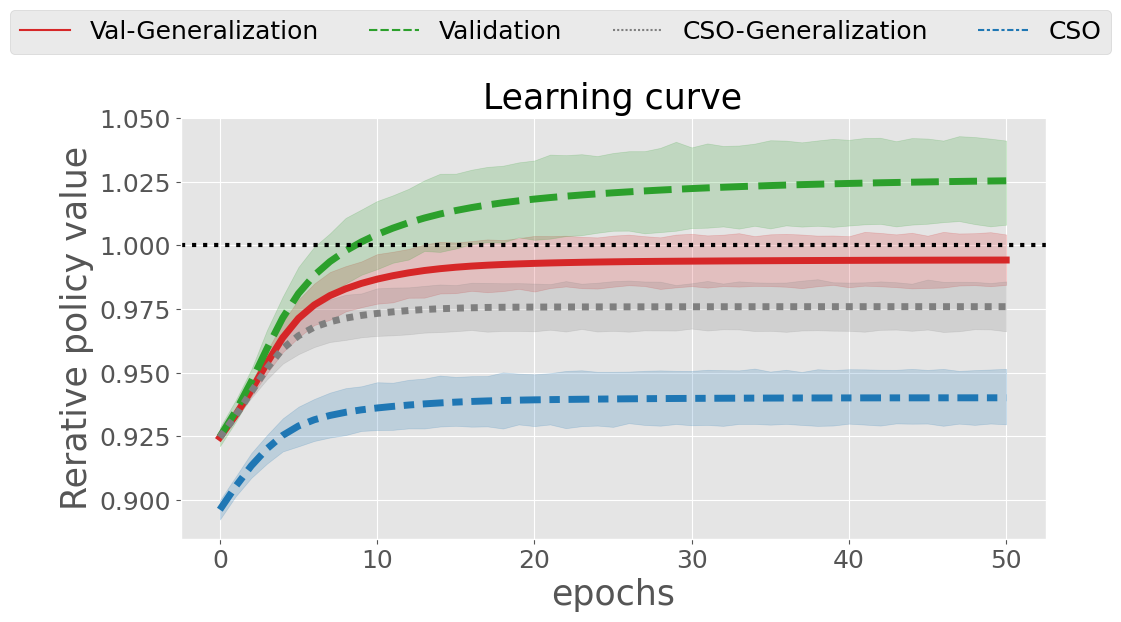

In [5]:
visualize_learning_curve(curve_df)

CSO cueve suggests that the generalization performance of CSO (CSO-Generalization) is larger than CSO value for each epoch with probability at least 1 - \delta.